In [64]:
!pip install pybbn -q

In [65]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [66]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
dataframe=pd.read_csv('weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
dataframe=dataframe[pd.isnull(dataframe['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
dataframe=dataframe.fillna(dataframe.mean())

# Create bands for variables that we want to use in the model
dataframe['WindGustSpeedCat']=dataframe['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
dataframe['Humidity9amCat']=dataframe['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
dataframe['Humidity3pmCat']=dataframe['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

# Show a snaphsot of data
dataframe

<ipython-input-66-5f639827bb0b>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataframe=dataframe.fillna(dataframe.mean())


Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW   
1       7.624853         WNW           44.0        NNW        WSW   
2       7.624853         WSW           46.0          W        WSW   
3       7.624853          NE           24.0         SE          E   
4       7.624853           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145454  7.624853           E           31.0        ESE          E   
145455  7.624853           E           31.0         SE        ENE   
145456  7.624853         NNW           22.0         SE          N   
145457  7.624853           N           37.0         SE        WNW   
145458  7.624853          SE           28.0        SSE          N   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145454          15.0          13.0         59.0         27.0       1024.7   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1  8.000000  4.503167     16.9     21.8        No   
1            1007.8  4.437189  4.503167     17.2     24.3        No   
2            1008.7  4.437189  2.000000     21.0     23.2        No   
3            1012.8  4.437189  4.503167     18.1     26.5        No   
4            1006.0  7.000000  8.000000     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145454       1021.2  4.437189  4.503167      9.4     20.9        No   
145455       1020.3  4.437189  4.503167     10.1     22.4        No   
145456       1019.1  4.437189  4.503167     10.9     24.5        No   
145457       1016.8  4.437189  4.503167     12.5     26.1        No   
145458       1016.5  3.000000  2.000000     15.1     26.0        No   

       RainTomorrow WindGustSpeedCat Humidity9amCat Humidity3pmCat  
0                No          1.40-50          1.>60         0.<=60  
1                No          1.40-50         0.<=60         0.<=60  
2                No          1.40-50         0.<=60         0.<=60  
3                No           0.<=40         0.<=60         0.<=60  
4                No          1.40-50          1.>60         0.<=60  
...             ...              ...            ...            ...  
145454           No           0.<=40         0.<=60        

In [67]:
dataframe=dataframe[pd.isnull(dataframe['RainTomorrow'])==False]
dataframe=dataframe.fillna(dataframe.mean())

<ipython-input-67-e0986c319d49>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dataframe=dataframe.fillna(dataframe.mean())


In [68]:
for column in dataframe.select_dtypes(include=['object']):
    dataframe[column].fillna(dataframe[column].mode()[0], inplace=True)

In [69]:
dataframe

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW   
1       7.624853         WNW           44.0        NNW        WSW   
2       7.624853         WSW           46.0          W        WSW   
3       7.624853          NE           24.0         SE          E   
4       7.624853           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145454  7.624853           E           31.0        ESE          E   
145455  7.624853           E           31.0         SE        ENE   
145456  7.624853         NNW           22.0         SE          N   
145457  7.624853           N           37.0         SE        WNW   
145458  7.624853          SE           28.0        SSE          N   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145454          15.0          13.0         59.0         27.0       1024.7   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1  8.000000  4.503167     16.9     21.8        No   
1            1007.8  4.437189  4.503167     17.2     24.3        No   
2            1008.7  4.437189  2.000000     21.0     23.2        No   
3            1012.8  4.437189  4.503167     18.1     26.5        No   
4            1006.0  7.000000  8.000000     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145454       1021.2  4.437189  4.503167      9.4     20.9        No   
145455       1020.3  4.437189  4.503167     10.1     22.4        No   
145456       1019.1  4.437189  4.503167     10.9     24.5        No   
145457       1016.8  4.437189  4.503167     12.5     26.1        No   
145458       1016.5  3.000000  2.000000     15.1     26.0        No   

       RainTomorrow WindGustSpeedCat Humidity9amCat Humidity3pmCat  
0                No          1.40-50          1.>60         0.<=60  
1                No          1.40-50         0.<=60         0.<=60  
2                No          1.40-50         0.<=60         0.<=60  
3                No           0.<=40         0.<=60         0.<=60  
4                No          1.40-50          1.>60         0.<=60  
...             ...              ...            ...            ...  
145454           No           0.<=40         0.<=60        

In [70]:
dataframe.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
WindGustSpeedCat    0
Humidity9amCat      0
Humidity3pmCat      0
dtype: int64

In [71]:
dataframe['Temp9amCat']=dataframe['Temp9am'].apply(lambda x: 'cat 1: x<15 ' if x<15 else 'cat 2: 15<=x<=26' if 15<x<=26 else 'cat 3: x>26')
dataframe['Temp3pmCat']=dataframe['Temp3pm'].apply(lambda x: 'cat 2: x<24' if x<24 else 'cat 2: 24<=x<=36' if 24<=x<=36 else 'cat 3: x>36')
dataframe['WindSpeed9amCat']=dataframe['WindSpeed9am'].apply(lambda x: 'cat 1: x<16' if x<16 else 'cat 2: x>=16')
dataframe['WindSpeed3pmCat']=dataframe['WindSpeed3pm'].apply(lambda x: 'cat 1: x<15' if x<15 else 'cat 2: x>=15')
dataframe

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
0       2008-12-01   Albury     13.4     22.9       0.6     5.469824   
1       2008-12-02   Albury      7.4     25.1       0.0     5.469824   
2       2008-12-03   Albury     12.9     25.7       0.0     5.469824   
3       2008-12-04   Albury      9.2     28.0       0.0     5.469824   
4       2008-12-05   Albury     17.5     32.3       1.0     5.469824   
...            ...      ...      ...      ...       ...          ...   
145454  2017-06-20    Uluru      3.5     21.8       0.0     5.469824   
145455  2017-06-21    Uluru      2.8     23.4       0.0     5.469824   
145456  2017-06-22    Uluru      3.6     25.3       0.0     5.469824   
145457  2017-06-23    Uluru      5.4     26.9       0.0     5.469824   
145458  2017-06-24    Uluru      7.8     27.0       0.0     5.469824   

        Sunshine WindGustDir  WindGustSpeed WindDir9am WindDir3pm  \
0       7.624853           W           44.0          W        WNW   
1       7.624853         WNW           44.0        NNW        WSW   
2       7.624853         WSW           46.0          W        WSW   
3       7.624853          NE           24.0         SE          E   
4       7.624853           W           41.0        ENE         NW   
...          ...         ...            ...        ...        ...   
145454  7.624853           E           31.0        ESE          E   
145455  7.624853           E           31.0         SE        ENE   
145456  7.624853         NNW           22.0         SE          N   
145457  7.624853           N           37.0         SE        WNW   
145458  7.624853          SE           28.0        SSE          N   

        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0               20.0          24.0         71.0         22.0       1007.7   
1                4.0          22.0         44.0         25.0       1010.6   
2               19.0          26.0         38.0         30.0       1007.6   
3               11.0           9.0         45.0         16.0       1017.6   
4                7.0          20.0         82.0         33.0       1010.8   
...              ...           ...          ...          ...          ...   
145454          15.0          13.0         59.0         27.0       1024.7   
145455          13.0          11.0         51.0         24.0       1024.6   
145456          13.0           9.0         56.0         21.0       1023.5   
145457           9.0           9.0         53.0         24.0       1021.0   
145458          13.0           7.0         51.0         24.0       1019.4   

        Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm RainToday  \
0            1007.1  8.000000  4.503167     16.9     21.8        No   
1            1007.8  4.437189  4.503167     17.2     24.3        No   
2            1008.7  4.437189  2.000000     21.0     23.2        No   
3            1012.8  4.437189  4.503167     18.1     26.5        No   
4            1006.0  7.000000  8.000000     17.8     29.7        No   
...             ...       ...       ...      ...      ...       ...   
145454       1021.2  4.437189  4.503167      9.4     20.9        No   
145455       1020.3  4.437189  4.503167     10.1     22.4        No   
145456       1019.1  4.437189  4.503167     10.9     24.5        No   
145457       1016.8  4.437189  4.503167     12.5     26.1        No   
145458       1016.5  3.000000  2.000000     15.1     26.0        No   

       RainTomorrow WindGustSpeedCat Humidity9amCat Humidity3pmCat  \
0                No          1.40-50          1.>60         0.<=60   
1                No          1.40-50         0.<=60         0.<=60   
2                No          1.40-50         0.<=60         0.<=60   
3                No           0.<=40         0.<=60         0.<=60   
4                No          1.40-50          1.>60         0.<=60   
...             ...              ...            ...            ...   
145454           No           0.<=40         0.<=60 

In [72]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            if parent2==None:
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [73]:
T9am = BbnNode(Variable(0, 'T9am', ['<15', '15-26', '>26']), probs(dataframe, child='Temp9amCat'))
T3pm = BbnNode(Variable(1, 'T3pm', ['<24', '24-36', '>36']), probs(dataframe, child='Temp3pmCat', parent1='Temp9amCat'))
WS9am = BbnNode(Variable(2, 'WS9am', ['<16', '>=16']), probs(dataframe, child='WindSpeed9amCat'))
WS3pm = BbnNode(Variable(3, 'WS3pm', ['<15', '>=15']), probs(dataframe, child='WindSpeed3pmCat', parent1='WindSpeed9amCat'))
RT = BbnNode(Variable(4, 'RT', ['No', 'Yes']), probs(dataframe, child='RainTomorrow', parent1='Temp3pmCat', parent2='WindSpeed3pmCat'))
bbn = Bbn() \
    .add_node(T9am) \
    .add_node(T3pm) \
    .add_node(WS9am) \
    .add_node(WS3pm) \
    .add_node(RT) \
    .add_edge(Edge(T9am, T3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(T3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(WS9am, WS3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(WS3pm, RT, EdgeType.DIRECTED))
join_tree = InferenceController.apply(bbn)

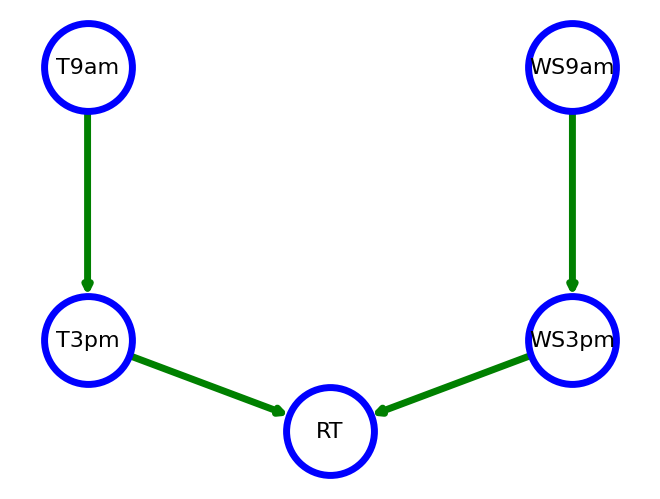

In [74]:
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 2), 3: (1, 0.5), 4: (0, 0)}
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "blue",
    "edge_color": "green",
    "linewidths": 5,
    "width": 5,}
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [75]:
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('***************************')
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
***************************
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
***************************
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.32668
1=24-36|0.64886
1=>36|0.02447
***************************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.39733
0=15-26|0.50187
0=>26|0.10079
***************************
Node: 4|RT|No,Yes
Values:
4=No|0.77556
4=Yes|0.22444
***************************


In [76]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

In [77]:
# Use above function to add evidence
evidence('ev1', 'T9am', '15-26', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
***************************
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
***************************
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.49023
1=24-36|0.50018
1=>36|0.00960
***************************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.00000
0=15-26|1.00000
0=>26|0.00000
***************************
Node: 4|RT|No,Yes
Values:
4=No|0.79133
4=Yes|0.20867
***************************


In [78]:
# Use above function to add evidence
evidence('ev2', 'T9am', '<15', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
***************************
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
***************************
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.02476
1=24-36|0.97522
1=>36|0.00002
***************************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
***************************
Node: 4|RT|No,Yes
Values:
4=No|0.73665
4=Yes|0.26335
***************************


In [79]:
# Use above function to add evidence
evidence('ev3', 'T3pm', '24-36', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
***************************
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
***************************
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|0.00000
1=24-36|1.00000
1=>36|0.00000
***************************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
***************************
Node: 4|RT|No,Yes
Values:
4=No|0.73383
4=Yes|0.26617
***************************


In [80]:
# Use above function to add evidence
evidence('ev4', 'T3pm', '<24', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
***************************
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
***************************
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|1.00000
1=24-36|0.00000
1=>36|0.00000
***************************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|1.00000
0=15-26|0.00000
0=>26|0.00000
***************************
Node: 4|RT|No,Yes
Values:
4=No|0.84743
4=Yes|0.15257
***************************


In [81]:
# Use above function to add evidence
evidence('ev5', 'T9am', '<15', 1.0)

# Print marginal probabilities
print_probs()

Node: 3|WS3pm|<15,>=15
Values:
3=<15|0.32095
3=>=15|0.67905
***************************
Node: 2|WS9am|<16,>=16
Values:
2=<16|0.62263
2=>=16|0.37737
***************************
Node: 1|T3pm|<24,24-36,>36
Values:
1=<24|1.00000
1=24-36|0.00000
1=>36|0.00000
***************************
Node: 0|T9am|<15,15-26,>26
Values:
0=<15|0.03012
0=15-26|0.75314
0=>26|0.21674
***************************
Node: 4|RT|No,Yes
Values:
4=No|0.84743
4=Yes|0.15257
***************************
